# <a href="https://mipt-stats.gitlab.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Занятие 2. Метод $k$ ближайших соседей.

В этом ноутбуке мы посмотрим на пример применения метода kNN для искуственно сгенерированных данных на задаче классификации.

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set(style='dark', font_scale=1.3)

import warnings
warnings.filterwarnings('ignore')

### Генерация данных

Сгенерируем данные из двух двумерных гауссовских распределений с помощью функции `make_blobs`.

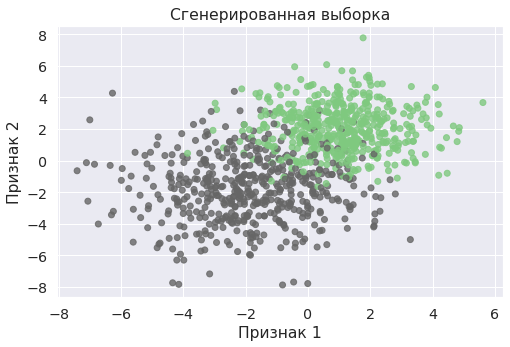

In [2]:
X, y = make_blobs(
    n_samples=(500, 500),  # количество точек в каждом кластере
    centers=[[1, 2], [-2, -2]],  # центры кластеров
    cluster_std=[1.5, 2],  # стандартные отклонения по кластерам
    random_state=42  # зерно случайности
)

plt.figure(figsize=(8, 5))  # создаем фигуру
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')  # рисуем точки
plt.grid()  # добавление сетки на график
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.title('Сгенерированная выборка')
plt.show()  # печатаем график

Посмотрим еще на размеры полученных данных

In [3]:
X.shape, y.shape

((1000, 2), (1000,))

### Применение метода

В `sklearn.neighbors` метод kNN представлен классами `KNeighborsClassifier` и `KNeighborsRegressor` для классификации и регрессии соответственно.

Оба метода имеют следующие параметры:
* `n_neighbors` &mdash; количество ближайших соседей, используемых для предсказания;
* `weights` &mdash; способ вычисления весов объектов из набора k ближайших соседей: 
    - `uniform` для одинакового веса для всех точек, 
    - `distance` для весов, пропорциональных обратному расстоянию;
* `metric` &mdash; метрика, по которой считаются ближайшие соседи;
* `p` &mdash; порядок расстояния Минковского между точками: $$\rho(x, y) = \left( \sum_{i=1}^d |x_i - y_i|^p \right)^{1/p};$$

Разделим на обучающую и тестовую выборки

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((850, 2), (150, 2), (850,), (150,))

Обучим метод трех ближайших соседей

In [5]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Качество на тесте

In [6]:
print(f'accuracy: {accuracy_score(y_test, model.predict(X_test)) :.3}')

accuracy: 0.907


### Визуализация

Визуализируем предсказания kNN для различных $k$. Для этого вычислим предсказания по сетке и нарисуем полученные классы.

In [7]:
def generate_grid(train_sample, border=1.0, step=0.05):
    '''
    Генерация сетки для вычисления предсказаний.
    
    :param train_sample: (np.ndarray)
        Точки выборки, по которым строилась модель
    :param border: (float)
        Отступ от максимальных и минимальных значений выборки по обеим координатам
    :param step: (float)
        Шаг сетки
    '''
    
    return np.meshgrid(
        np.arange(min(train_sample[:, 0]) - border, 
                  max(train_sample[:, 0]) + border, 
                  step),
        np.arange(min(train_sample[:, 1]) - border, 
                  max(train_sample[:, 1]) + border, 
                  step)
    )

In [8]:
def create_picture(X_train, y_train, model, border=1.0, 
                   step=0.05, figsize=(18, 5), 
                   cmap='winter', alpha=1):
    '''
    Визуализация предсказаний классов на плоскости и точек обучающей выборки.
    
    :param X_train:
        Точки обучающей выборки
    :param y_train:
        Классы точек обучающей выборки
    :param model:
        Модель-классификатор, для которой визуализируются предсказания
    '''
    
    # == Создание сетки ==
    grid = generate_grid(X_train, border, step)
    # Выворачивание сетки для приведения к форме выборки
    grid_ravel = np.c_[grid[0].ravel(), grid[1].ravel()]
    
    # == Предсказание значений для сетки == 
    # Берем вероятности для первого класса
    grid_predicted_ravel = model.predict_proba(grid_ravel)[:, 1]
    # Подгоняем размер
    grid_predicted = grid_predicted_ravel.reshape(grid[0].shape)
    
    
    # == Построение фигуры ==
    plt.figure(figsize=figsize)
    
    # Визуализируем саму классификацию на левом графике
    plt.subplot(1, 2, 1)
    plt.pcolormesh(grid[0], grid[1], grid_predicted > 0.5, cmap=cmap)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                alpha=alpha, cmap=cmap, edgecolor='black')
    plt.xlim((min(grid_ravel[:, 0]), max(grid_ravel[:, 0])))
    plt.ylim((min(grid_ravel[:, 1]), max(grid_ravel[:, 1])))
    plt.title(u'Классификация {}-NN'.format(model.get_params()['n_neighbors']))
    
    # Визуализируем вероятности классов на правом графике
    plt.subplot(1, 2, 2)
    plt.pcolormesh(grid[0], grid[1], grid_predicted, cmap=cmap)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
                alpha=alpha, cmap=cmap, edgecolor='black')
    plt.xlim((min(grid_ravel[:, 0]), max(grid_ravel[:, 0])))
    plt.ylim((min(grid_ravel[:, 1]), max(grid_ravel[:, 1])))
    plt.title(u'Вероятности {}-NN'.format(model.get_params()['n_neighbors']))
    
    plt.show()

Сначала действуем в метрике $\ell_2$, то есть обычная евклидова метрика.

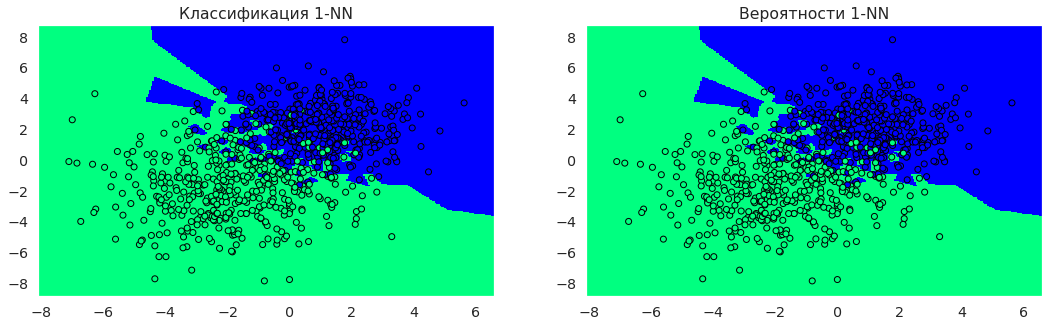

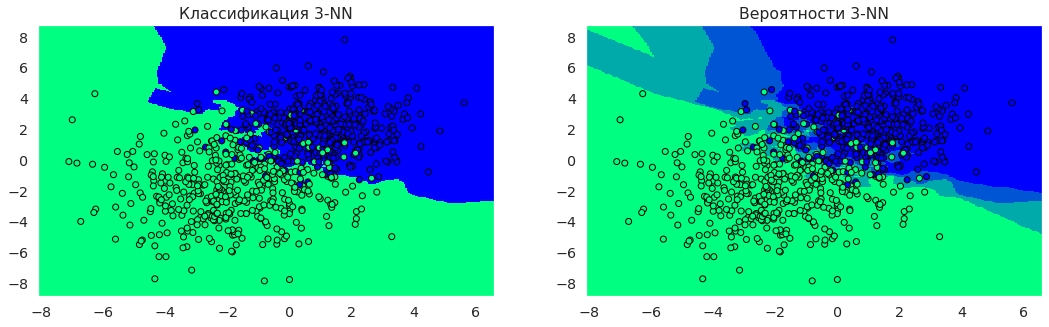

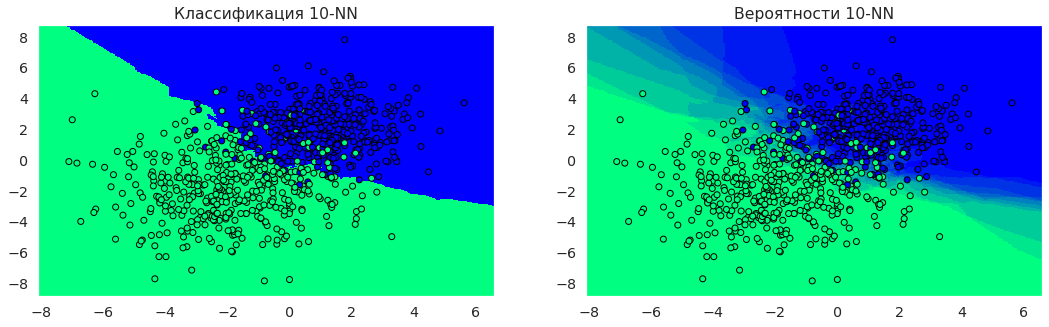

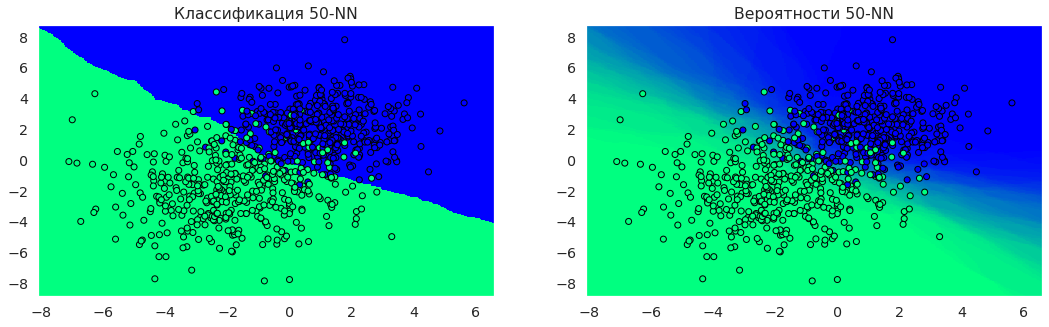

In [9]:
for n_neighbors in [1, 3, 10, 50]:
    create_picture(
        X_train, 
        y_train, 
        KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    )

Теперь построим аналогичные графики для метрики $\ell_1$, то есть сумма модулей разностей координат.

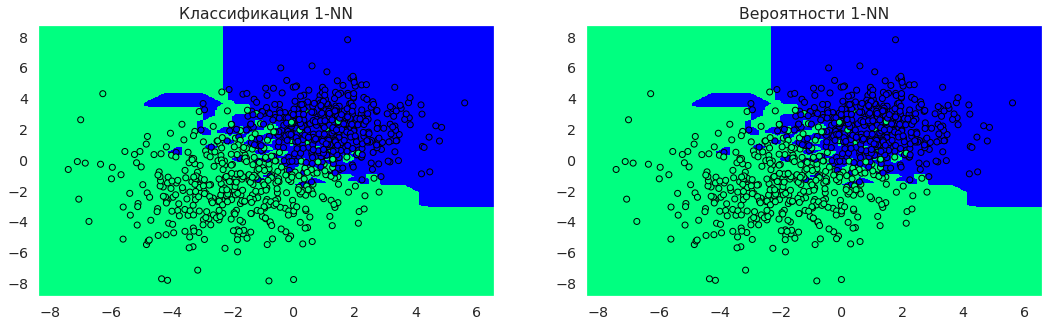

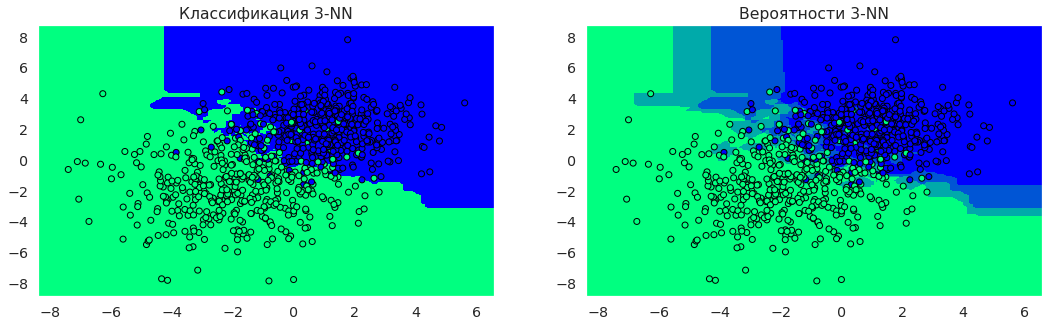

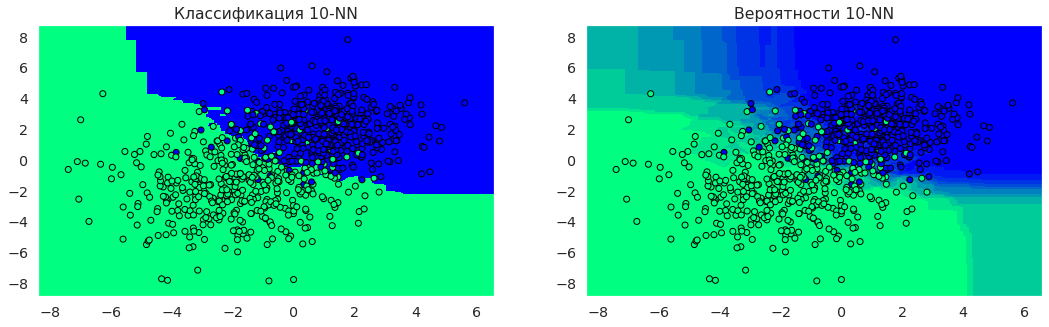

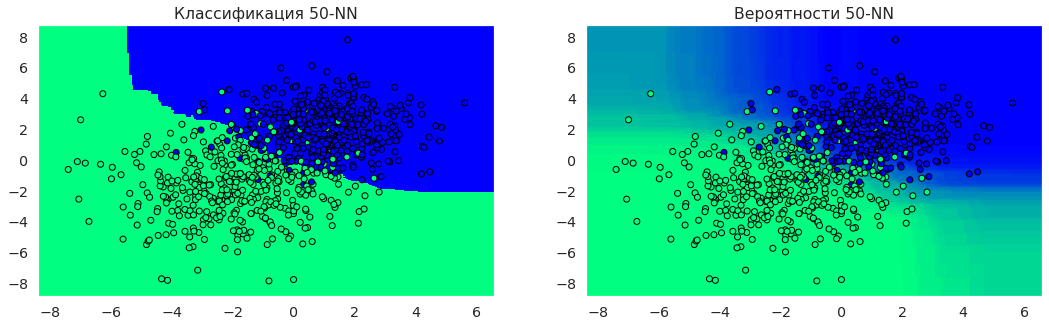

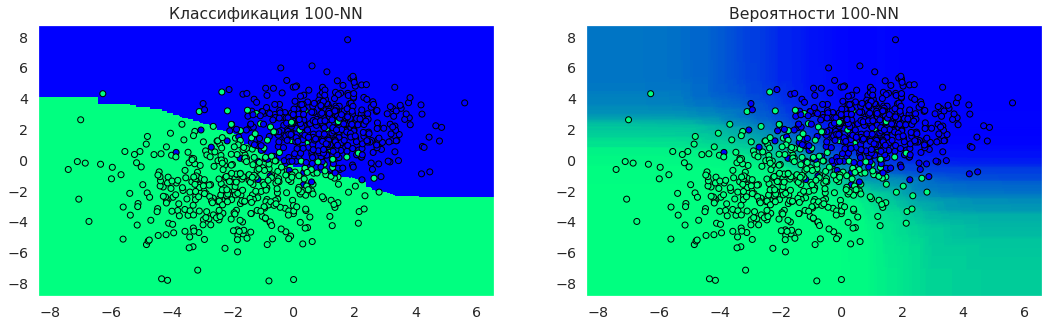

In [ ]:
for n_neighbors in [1, 3, 10, 50, 100]:
    create_picture(
        X_train, 
        y_train, 
        KNeighborsClassifier(n_neighbors=n_neighbors, p=1).fit(X_train, y_train)
    )

**Вывод:**

При увеличении числа соседей разделяющая кривая получается более гладкой. При маленьком же числе рассматриваемых соседей модель чувствительна к наложению классов, из-за чего в предсказаниях разделяющая поверхность очень неровная. Также при большом числе классов переход между классами на графике вероятностей намного более плавный.

### Реальные данные: Ирисы Фишера

Рассмотрим датасет, который называется <a href="https://ru.wikipedia.org/wiki/Ирисы_Фишера">Ирисы Фишера</a>. Датасет содержит наблюдения за 150 разными цветками ирисов, данные по каждому цветку расположены в строках. 
В стобцах записаны длина и ширина чашелистика, длина и ширина лепестка, вид ириса. 


In [ ]:
iris = sns.load_dataset('iris')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


Покажем на графиках зависимости ширины лепестка от его длины, а также аналогичный график зависимость для длины и ширины чашелистика. Разные виды цветков отмечены разными цветами.

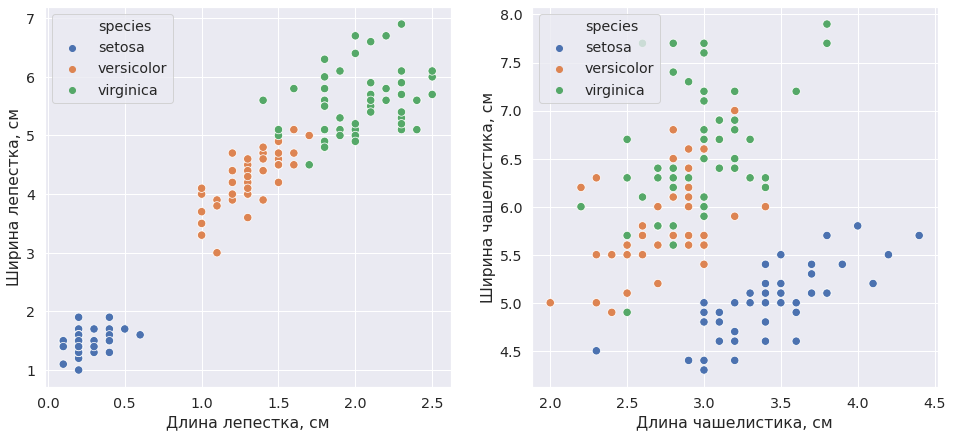

In [ ]:
# Объявляем фигуру из двух графиков и ее размер
plt.figure(figsize=(16, 7))

# Левый график
plt.subplot(121)
sns.scatterplot(
    data=iris,  # из этой таблицы нарисовать точки
    x='petal_width', y='petal_length',  # с этими координатами,
    hue='species', # для которых цвет определить согласно этому столбцу
    s=70  # размер точек
)
plt.xlabel('Длина лепестка, см')
plt.ylabel('Ширина лепестка, см')
plt.legend()  # добавить легенду
plt.grid()  # добавить сетку

# Правый график аналогично
plt.subplot(122)
sns.scatterplot(data=iris, x='sepal_width', y='sepal_length', hue='species', s=70)
plt.xlabel('Длина чашелистика, см')
plt.ylabel('Ширина чашелистика, см')
plt.legend()
plt.grid();

Как мы видим, в первом случае классы достаточно хорошо отделяются друг от друга, хотя два классе имеют небольшое пересечение. Во втором случае разделить два класса между собой уже намного труднее. Поэтому будем использовать длину и ширину лепестка.


Разделим на обучающую и тестовую выборки в соотношении 70:30.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    # поскольку iris это pandas-таблица, для нее нужно указывать iloc
    iris.iloc[:, :-1],  # берем все колонки кроме последней в признаки
    iris.iloc[:, -1],  # последнюю в целевую переменную
    test_size=0.15
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127, 4), (23, 4), (127,), (23,))

Поскольку `iris` была `pandas` таблицей, то результаты тоже будут представлены объектами `pandas`. Это следует иметь ввиду при дальнейшей работе.

In [ ]:
X_train.head()

,sepal_length,sepal_width,petal_length,petal_width
13,4.3,3.0,1.1,0.1
119,6.0,2.2,5.0,1.5
114,5.8,2.8,5.1,2.4
26,5.0,3.4,1.6,0.4
130,7.4,2.8,6.1,1.9


Целевая переменная осталась строковой. Этого в данном случае будет достаточно.

In [ ]:
y_train.head()

13        setosa
119    virginica
114    virginica
26        setosa
130    virginica
Name: species, dtype: object

Обучим метод трех ближайших соседей

In [ ]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

Получим предсказания модели

In [ ]:
y_pred = model.predict(X_test)
y_pred

array(['virginica', 'versicolor', 'versicolor', 'virginica', 'setosa',
       'versicolor', 'virginica', 'setosa', 'setosa', 'virginica',
       'versicolor', 'virginica', 'versicolor', 'versicolor', 'setosa',
       'virginica', 'versicolor', 'virginica', 'setosa', 'versicolor',
       'setosa', 'virginica', 'virginica'], dtype=object)

Качество на тесте

In [ ]:
print(f'accuracy: {accuracy_score(y_test, y_pred) :.3}')

accuracy: 0.957


Покажем на графике, что отражает полученное число.

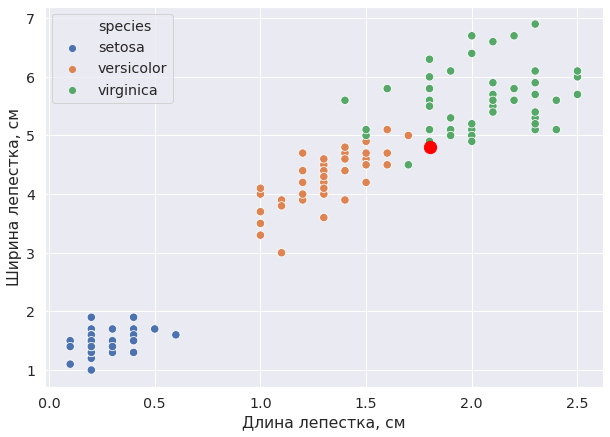

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='petal_width', y='petal_length', data=iris, hue='species', s=70)
plt.xlabel('Длина лепестка, см')
plt.ylabel('Ширина лепестка, см')
plt.legend(loc=2)
plt.grid()

# Перебираем все объекты из теста
for i in range(len(y_test)):
    # Если предсказание неправильное
    if np.array(y_test)[i] != y_pred[i]:
        # то подсвечиваем точку красным
        plt.scatter(X_test.iloc[i, 3], X_test.iloc[i, 2], color='red', s=150)

Красным цветом обозначены точки, для которых классификация сработала неправильно. 